In [1]:
%matplotlib inline

Everett Wetchler 2019-01-18 07:43:08 PST

numpy 1.14.5
pandas 0.23.3
matplotlib 2.2.2
seaborn 0.7.1
datadotworld 1.6.0
watermark 1.6.1


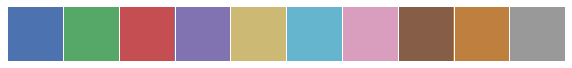

In [2]:
####################################################
# Boilerplate import/setup code for general analysis
# everett.wetchler@gmail.com
####################################################

import datetime as dt
import os
import random
import simplejson as json

import datadotworld as dw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Jupyter setup
%matplotlib inline

## Graphical setup
mpl.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# Set up a longer default color palette of very different
# colors for plotting categorical data.
set1 = sns.color_palette('Set1', 9, desat=.5)
super_palette = sns.color_palette('deep', 6) + [set1[7], set1[6], set1[4], set1[8]]
sns.set_palette(super_palette)
sns.palplot(sns.color_palette())

# It's useful to have some named colors handy
(SNS_BLUE, SNS_GREEN, SNS_RED,
 SNS_PURPLE, SNS_YELLOW, SNS_CYAN,
 SNS_PINK, SNS_BROWN, SNS_ORANGE,
 SNS_GRAY) = super_palette

# Watermark extension to print version/system information
# Flags:
# -a [author] -d (date) -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version) -p [packages] (package info)
%load_ext watermark
%watermark -a 'Everett Wetchler' -d -t -z -w -p numpy,pandas,matplotlib,seaborn,datadotworld

####################################################
# END Boilerplate
####################################################

In [3]:
import scipy
from scipy.optimize import curve_fit

In [4]:
# Fit a sigmoid curve to the individual calibration data. 
# Data output from calibration is a matrix with column 1 = number of pulses (x)
# and column 2 = subjective rating (y)

# Sigmoid function has 4 parameters:
# a scales the height of the sigmoid
# k is the steepness of the sigmoid
# x0 defines the midpoint of the sigmoid (i.e. x ofset)
# y0 defines the y offset of the sigmoid

# Ideally for a pain distribution  the y offset should always be 1 
# (the sigmoid starts at 1)

# Params are the parameters of the sigmoid and ss are the subjective scores
# for the linearly increasing values of x


# fileName = 'LouisData'
# dataFile = pd.read_csv(fileName+'.csv')  # a simple text file with 'comma-separated-values'
# ydata = np.array(dataFile.rating)
# xdata = np.array(dataFile.num_pulses)

# Generate fake data to tinker
### I just reran this block a bunch of times until I got "realistic" looking data

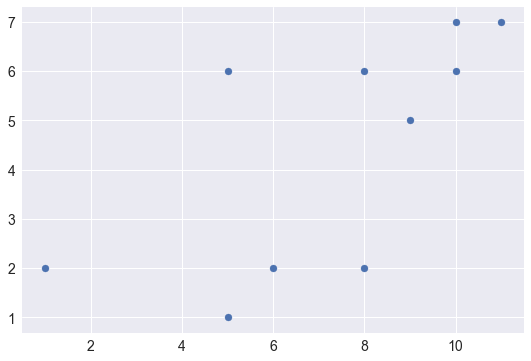

In [21]:
N = 10
xdata = [random.randint(1, 15) for i in range(N)]
ydata = [random.randint(1, 7) for i in range(N)]
plt.scatter(xdata,ydata)

# Helper code

In [22]:
def painsigmoid(x, steepness, midpoint):
    return 9 * (1 / (1+np.exp(-steepness*(x-midpoint)))) + 1

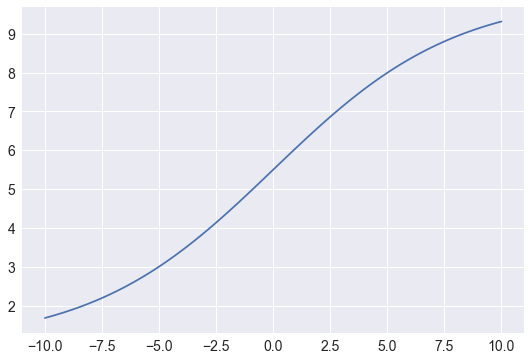

In [23]:
x = np.linspace(-10, 10, 100)
plt.plot(x, painsigmoid(x, .25, 0))

# Naive curve fit, no parameter bounding

[-3.26027929 -7.6025407 ]


/Users/everettwetchler/Library/Python/3.6/lib/python/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Text(0.5,0,'Num pulses')

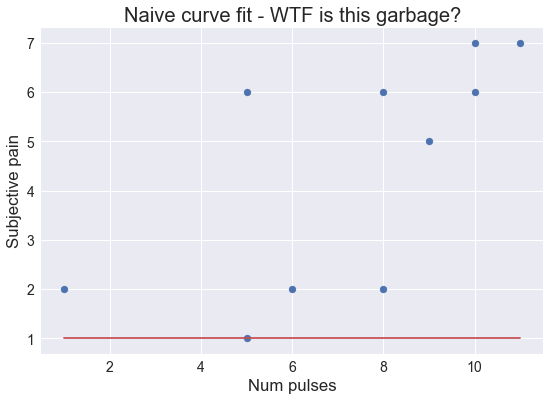

In [26]:
fig, ax = plt.subplots(1)
ax.scatter(xdata, ydata)

popt, pcov = curve_fit(painsigmoid, xdata, ydata)
print(popt)
x = np.array(range(1, max(xdata)+1))
y = painsigmoid(x, *popt)
ax.plot(x, y, color=SNS_RED)
ax.set_title("Naive curve fit - WTF is this garbage?")
ax.set_ylabel("Subjective pain")
ax.set_xlabel("Num pulses")

# Find sigmoids that pass (nearly) through (1,1) and (max(x), 7)

In [28]:
solutions = []
tolerance = 0.25
tried = 0
for steepness in np.arange(0, 5, .1):
    for midpoint in np.arange(1, max(xdata), .1):
        tried += 1
        if (painsigmoid(1, steepness, midpoint) < (1 + tolerance)
            and (7 - tolerance) < painsigmoid(max(xdata), steepness, midpoint) <= 7.0):
            solutions.append((steepness, midpoint))

print('Found %d acceptable sigmoids out of %d tried' % (len(solutions), tried))
steepness_range = (min(s[0] for s in solutions), max(s[0] for s in solutions))
midpoint_range = (min(s[1] for s in solutions), max(s[1] for s in solutions))
print('Steepness range: [%.2f, %.2f]' % steepness_range)
print('Midpoint range: [%.2f, %.2f]' % midpoint_range)

Found 24 acceptable sigmoids out of 5000 tried
Steepness range: [0.50, 3.40]
Midpoint range: [9.70, 10.80]


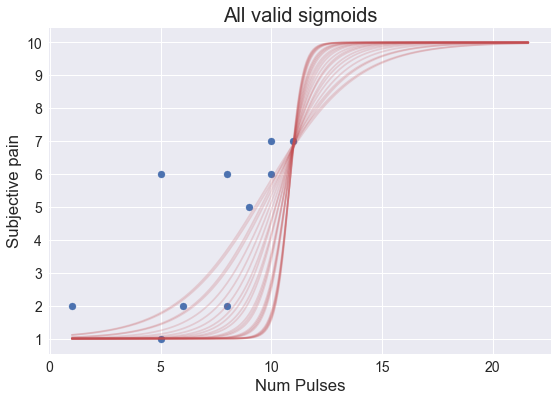

In [30]:
fig, ax = plt.subplots(1)
ax.scatter(xdata, ydata)

max_midpoint = max(s[1] for s in solutions)
x = np.arange(1, max_midpoint * 2, .1)
for s in solutions:
    y = painsigmoid(x, s[0], s[1])
    ax.plot(x, y, color=SNS_RED, alpha=0.2)

ax.set_yticks(np.arange(1, 11, 1))
ax.set_ylabel("Subjective pain")
ax.set_xlabel("Num Pulses")
ax.set_title("All valid sigmoids")
pass

# Using the new bounds for the parameters, dial in the best-fit sigmoid

Text(0.5,1,'Best fit curve: steepness=0.50, midpoint=9.70')

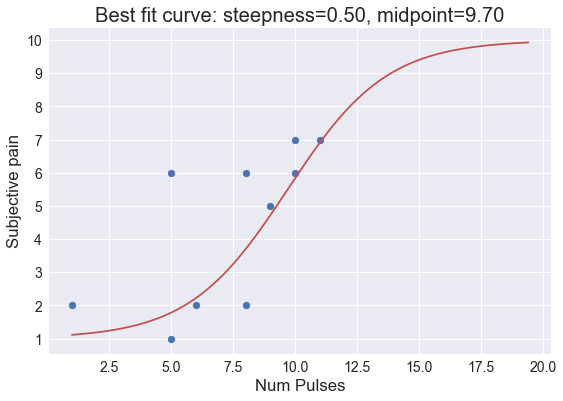

In [31]:
popt, pcov = curve_fit(painsigmoid, xdata, ydata,
                       bounds=([steepness_range[0], midpoint_range[0]],
                               [steepness_range[1], midpoint_range[1]]))

fig, ax = plt.subplots(1)

x = np.array(np.arange(1, popt[1]*2, .1))
y = painsigmoid(x, *popt)
ax.scatter(xdata, ydata)
ax.plot(x, y, color=SNS_RED)

# Plot prettifying
ax.set_yticks(np.arange(1, 11, 1))
ax.set_ylabel("Subjective pain")
ax.set_xlabel("Num Pulses")
ax.set_title("Best fit curve: steepness=%.2f, midpoint=%.2f" % tuple(popt))

In [34]:
for x in np.arange(1, max_midpoint*2, 0.1):
    print("%.2f,%.2f" % (x, painsigmoid(x, *popt)))

1.00,1.11
1.10,1.12
1.20,1.13
1.30,1.13
1.40,1.14
1.50,1.15
1.60,1.15
1.70,1.16
1.80,1.17
1.90,1.18
2.00,1.19
2.10,1.20
2.20,1.21
2.30,1.22
2.40,1.23
2.50,1.24
2.60,1.25
2.70,1.26
2.80,1.28
2.90,1.29
3.00,1.31
3.10,1.32
3.20,1.34
3.30,1.35
3.40,1.37
3.50,1.39
3.60,1.41
3.70,1.43
3.80,1.45
3.90,1.47
4.00,1.49
4.10,1.52
4.20,1.54
4.30,1.57
4.40,1.59
4.50,1.62
4.60,1.65
4.70,1.68
4.80,1.71
4.90,1.75
5.00,1.78
5.10,1.82
5.20,1.86
5.30,1.90
5.40,1.94
5.50,1.98
5.60,2.03
5.70,2.07
5.80,2.12
5.90,2.17
6.00,2.22
6.10,2.28
6.20,2.33
6.30,2.39
6.40,2.45
6.50,2.51
6.60,2.58
6.70,2.64
6.80,2.71
6.90,2.78
7.00,2.85
7.10,2.93
7.20,3.00
7.30,3.08
7.40,3.16
7.50,3.25
7.60,3.33
7.70,3.42
7.80,3.51
7.90,3.60
8.00,3.69
8.10,3.79
8.20,3.89
8.30,3.99
8.40,4.09
8.50,4.19
8.60,4.29
8.70,4.40
8.80,4.50
8.90,4.61
9.00,4.72
9.10,4.83
9.20,4.94
9.30,5.05
9.40,5.16
9.50,5.28
9.60,5.39
9.70,5.50
9.80,5.61
9.90,5.72
10.00,5.84
10.10,5.95
10.20,6.06
10.30,6.17
10.40,6.28
10.50,6.39
10.60,6.50
10.70,6.60
10.80,6.71
1